!pip install -U pip
!pip install --use-pep517 suod 
!pip install polars catboost yake threadpoolctl 
!pip install polars-splitters

## Блок загрузки

In [1]:
# PHIK Pipeline с обработкой текстовых данных
import polars as pl
import numpy as np
import pandas as pd
import gc
import warnings
warnings.filterwarnings("ignore")

from catboost import CatBoostClassifier, Pool, cv

from sklearn.model_selection import StratifiedKFold, ParameterGrid
from sklearn.metrics import f1_score, classification_report, confusion_matrix, ConfusionMatrixDisplay
from pyod.models.cblof import CBLOF
import matplotlib.pyplot as plt

# Импорт PHIK
try:
    from phik.phik import phik_matrix
    from phik.report import plot_correlation_matrix
    print("✅ PHIK доступен")
except ImportError:
    print("❌ Устанавливаем PHIK...")
    import subprocess
    subprocess.run(["pip", "install", "phik"], check=True)
    from phik.phik import phik_matrix
    from phik.report import plot_correlation_matrix

RANDOM_STATE = 255
np.random.seed(RANDOM_STATE)

✅ PHIK доступен


## Иницируем класс TextAwarePHIKPipeline

In [2]:
class TextAwarePHIKPipeline:
    """Pipeline с правильной обработкой текстовых данных"""
    
    def __init__(self):
        self.random_state = RANDOM_STATE
        self.target = 'resolution'
        self.col_drop = ['id', 'ItemID', 'SellerID']
        
        # Пороги фильтрации
        self.hard_threshold_low = 0.2
        self.hard_threshold_high = 0.8
        
        # Модели
        self.zero_model = None
        self.hard_model = None
        self.soft_model = None 
        self.error_model = None
        self.anomaly_detector = None
        
        # Признаки для каждого этапа
        self.zero_features = None
        self.hard_features = None
        self.soft_features = None
        self.error_features = None
        
        # Текстовые столбцы (определяются при загрузке)
        self.text_columns = None
        
        # GPU настройки
        self._detect_device()
        
        # Базовые параметры CatBoost
        self.base_catboost_params = {
            'random_seed': [self.random_state],
            'task_type': [self.task_type],
            'verbose': [False],
            'eval_metric': ['F1'],
            'custom_metric': ['Recall'],
            'loss_function': ['Logloss'],
            'use_best_model': [True],
            'early_stopping_rounds': [10],
            'thread_count': [3],
            'allow_writing_files': [False]
        }
        
        if self.task_type == 'GPU':
            self.base_catboost_params.update({
                'gpu_ram_part': [0.8],
                'used_ram_limit': ['12gb']
            })
    
    def _detect_device(self):
        """Определение GPU/CPU"""
        try:
            from catboost.utils import get_gpu_device_count
            gpu_count = get_gpu_device_count()
            if gpu_count > 0:
                print(f"GPU доступен, количество устройств: {gpu_count}")
                self.task_type = 'GPU'
            else:
                print("GPU недоступен, используем CPU")
                self.task_type = 'CPU'
        except ImportError:
            print("GPU недоступен, используем CPU")
            self.task_type = 'CPU'
    
    def _identify_text_columns(self, df: pl.DataFrame):
        """Определение текстовых столбцов"""
        text_cols = []
        for col, dtype in df.schema.items():
            if col not in self.col_drop and col != self.target:
                if dtype == pl.String:
                    text_cols.append(col)
        
        self.text_columns = text_cols
        print(f"Найдено текстовых столбцов: {len(text_cols)} - {text_cols}")
        return text_cols

## Нулевой отбор признаков

In [3]:
def zero_stage_feature_selection(self, df: pl.DataFrame):
    """Нулевой этап: отбор важных признаков по CatBoost"""
    print("="*60)
    print("НУЛЕВОЙ ЭТАП: Отбор важных признаков по CatBoost")
    print("="*60)
    
    # Определяем текстовые столбцы
    text_cols = self._identify_text_columns(df)
    
    # Подготовка данных - разделение на числовые и текстовые
    numeric_cols = []
    for col, dtype in df.schema.items():
        if col not in self.col_drop and col != self.target and col not in text_cols:
            if dtype in [pl.Int8, pl.Int16, pl.Int32, pl.Int64, pl.Float32, pl.Float64]:
                numeric_cols.append(col)
    
    print(f"Числовых признаков: {len(numeric_cols)}")
    print(f"Текстовых признаков: {len(text_cols)}")
    
    # Заполняем пропуски
    expressions = []
    for col in numeric_cols:
        if col in df.columns:
            expressions.append(pl.col(col).fill_null(0).alias(col))
    
    # Заполняем текстовые (НЕ УДАЛЯЕМ!)
    for col in text_cols:
        if col in df.columns:
            expressions.append(pl.col(col).fill_null("missing").alias(col))
    
    df_filled = df.with_columns(expressions) if expressions else df
    
    # Преобразуем в pandas
    df_pandas = df_filled.to_pandas()
    
    # Все доступные признаки (включая текстовые)
    feature_cols = numeric_cols + text_cols
    
    if len(feature_cols) == 0:
        print("❌ Нет признаков для анализа!")
        return df
    
    print(f"Всего признаков для анализа: {len(feature_cols)}")
    
    # Подготовка данных для CatBoost
    X_zero = df_pandas[feature_cols].copy()
    y_zero = df_pandas[self.target]
    
    # Определяем категориальные и текстовые признаки ПРАВИЛЬНО
    cat_features = []
    text_features = []
    
    for i, col in enumerate(X_zero.columns):
        if col in text_cols:
            # Текстовые - по ИНДЕКСАМ
            text_features.append(i)
            # Заполняем пропуски в тексте
            X_zero.iloc[:, i] = X_zero.iloc[:, i].fillna("missing").astype(str)
        elif col in numeric_cols:
            col_data = X_zero.iloc[:, i]
            unique_count = col_data.nunique()
            col_dtype = col_data.dtype
            
            # Категориальные - только int с <= 50 уникальных
            if (col_dtype in ['int64', 'int32', 'int16', 'int8'] and unique_count <= 50):
                cat_features.append(i)
    
    print(f"Категориальных признаков: {len(cat_features)}")
    print(f"Текстовых признаков: {len(text_features)}")
    
    # Простые параметры для анализа важности (без глубокой текстовой обработки)
    zero_params = {
        'random_seed': self.random_state,
        'task_type': self.task_type,
        'verbose': False,
        'eval_metric': 'F1',
        'custom_metric': 'Recall',
        'loss_function': 'Logloss',
        'use_best_model': True,
        'early_stopping_rounds': 10,
        'thread_count': 3,
        'allow_writing_files': False,
        'iterations': 200,
        'depth': 6,
        'use_best_model': False,
        'learning_rate': 0.1
    }
    
    print("Обучение модели для анализа важности признаков...")
    
    # Используем встроенную кросс-валидацию CatBoost
    train_pool = Pool(
        X_zero, y_zero, 
        cat_features=cat_features,
        text_features=text_features
    )
    
    # Встроенная CV CatBoost
    
    cv_results = cv(
        params=zero_params,
        pool=train_pool,
        fold_count=3,
        stratified=True,
        shuffle=True,
        early_stopping_rounds=50,
        verbose=False
    )
   
    
    if isinstance(cv_results, tuple):
        cv_results_df = cv_results[0]
    else:
        cv_results_df = cv_results
    
    print(f"CV F1: {cv_results_df['test-F1-mean'].iloc[-1]:.4f} ± {cv_results_df['test-F1-std'].iloc[-1]:.4f}")
    
    best_iteration = cv_results_df['test-F1-mean'].idxmax()
    best_score = cv_results_df.loc[best_iteration, 'test-F1-mean']
    
    #print(f"Лучшее количество итераций по CV: {best_iteration}, CV F1: {best_score:.4f}")
    zero_params['iterations'] = best_iteration
    # Обучаем финальную модель на всем датасете с найденной лучше итерацией
    self.zero_model = CatBoostClassifier(
        **zero_params, 
        
        cat_features=cat_features,
        text_features=text_features
    )
    self.zero_model.fit(train_pool, verbose=False)
    
    # Получаем важность признаков из обученной модели
    mean_importance = self.zero_model.get_feature_importance()
    
    importance_df = pd.DataFrame({
        'feature': X_zero.columns,
        'importance': mean_importance
    }).sort_values('importance', ascending=False)
    
    # Отбор топ-30 важных признаков (включая текстовые)
    top_n_features = 30
    self.zero_features = importance_df.head(top_n_features)['feature'].tolist()
    
    print(f"\nОтобрано {len(self.zero_features)} важных признаков:")
    for i, (_, row) in enumerate(importance_df.head(10).iterrows()):
        feat_type = "TEXT" if row['feature'] in text_cols else "NUM"
        print(f"  {i+1:2d}. {row['feature']:<25} {row['importance']:.4f} [{feat_type}]")
    
    
    # Показываем сколько текстовых попало в важные
    important_text_cols = [col for col in self.zero_features if col in text_cols]
    print(f"\n📊 Из важных признаков текстовых: {len(important_text_cols)}")
    
    # Визуализация важности признаков
    plt.figure(figsize=(12, 8))
    top_20 = importance_df.head(20)
    colors = ['red' if feat in text_cols else 'blue' for feat in top_20['feature']]
    plt.barh(range(len(top_20)), top_20['importance'], color=colors)
    plt.yticks(range(len(top_20)), top_20['feature'])
    plt.xlabel('Важность признака')
    plt.title('ТОП-20 важных признаков (Красные=Текстовые, Синие=Числовые)')
    plt.gca().invert_yaxis()
    plt.tight_layout()
    plt.show()
    
    # Сохраняем финальную модель
    self.zero_model = CatBoostClassifier(
        **zero_params, 
        cat_features=cat_features,
        text_features=text_features
    )
    self.zero_model.fit(train_pool, verbose=False)
    del X_zero, y_zero, df_pandas
    return df_filled

TextAwarePHIKPipeline.zero_stage_feature_selection = zero_stage_feature_selection

## Генерация hard признаков

In [4]:
def generate_features_hard(self, df: pl.DataFrame, keep_original=True):
    """Генерация признаков для HARD модели (только числовые преобразования)"""
    print("\nГенерация признаков для HARD модели...")
    
    expressions = []
    
    # 1. Базовые преобразования для важных ЧИСЛОВЫХ признаков
    for col in self.zero_features:
        
        
        if col in df.columns and col not in self.text_columns:
            # Числовые преобразования только для числовых столбцов
            col_dtype = df[col].dtype
            if col_dtype in [pl.Int8, pl.Int16, pl.Int32, pl.Int64, pl.Float32, pl.Float64]:                
                # Логарифм
                expressions.append(
                    pl.when(pl.col(col) > 0).then(pl.col(col).log()).otherwise(0).alias(f"{col}_log")
                )
                # Квадрат
                expressions.append(
                    (pl.col(col) ** 2).alias(f"{col}_sq")
                )
    
    # 2. Соотношения между ключевыми важными ЧИСЛОВЫМИ признаками
    key_numeric_cols = []
    for col in ['ItemAvailableCount', 'ItemVarietyCount', 'seller_time_alive', 'item_time_alive']:
        if col in self.zero_features and col in df.columns and col not in self.text_columns:
            col_dtype = df[col].dtype
            if col_dtype in [pl.Int8, pl.Int16, pl.Int32, pl.Int64, pl.Float32, pl.Float64]:
                key_numeric_cols.append(col)
    
    for i in range(len(key_numeric_cols)):
        for j in range(i + 1, len(key_numeric_cols)):
            col1, col2 = key_numeric_cols[i], key_numeric_cols[j]
            expressions.extend([
                (pl.col(col1) / (pl.col(col2) + 1)).alias(f"{col1}_{col2}_ratio"),
                (pl.col(col1) - pl.col(col2)).alias(f"{col1}_{col2}_diff")
            ])
    
    # 3. Обработка returns признаков
    returns_cols = [col for col in self.zero_features 
                   if 'return' in col.lower() and col in df.columns and col not in self.text_columns]
    for col in returns_cols:
        col_dtype = df[col].dtype
        if col_dtype in [pl.Int8, pl.Int16, pl.Int32, pl.Int64, pl.Float32, pl.Float64]:
            expressions.extend([
                (pl.col(col) > 0).cast(pl.Int8).alias(f"{col}_exists"),
                (pl.col(col) > 20).cast(pl.Int8).alias(f"{col}_high")
            ])
    
    if expressions:
        df = df.with_columns(expressions)
    
    print(f"Добавлено {len(expressions)} новых числовых признаков для HARD модели")
    
    return df
    
TextAwarePHIKPipeline.generate_features_hard = generate_features_hard

## Генерация soft признаков

In [5]:
def generate_features_soft(self, df: pl.DataFrame, keep_original=True):
    """Генерация дополнительных признаков для SOFT модели"""
    print("\nГенерация дополнительных признаков для SOFT модели...")
    
    expressions = []
    
    # Получаем важные ЧИСЛОВЫЕ признаки (топ-10)
    important_numeric_cols = []
    for col in self.zero_features[:10]:
        if col in df.columns and col not in self.text_columns:
            col_dtype = df[col].dtype
            if col_dtype in [pl.Int8, pl.Int16, pl.Int32, pl.Int64, pl.Float32, pl.Float64]:
                important_numeric_cols.append(col)
    
    # 1. Произведения между важными числовыми признаками
    for i in range(len(important_numeric_cols)):
        for j in range(i + 1, len(important_numeric_cols)):
            col1, col2 = important_numeric_cols[i], important_numeric_cols[j]
            expressions.extend([
                (pl.col(col1) * pl.col(col2)).alias(f"{col1}_{col2}_prod"),
                ((pl.col(col1) + pl.col(col2)) / 2).alias(f"{col1}_{col2}_mean")
            ])
    
    # 2. Полиномиальные признаки (ограничиваем топ-5)
    for col in important_numeric_cols[:5]:
        expressions.extend([
            (pl.col(col) ** 3).alias(f"{col}_cube"),
            pl.when(pl.col(col) != 0).then(1 / pl.col(col)).otherwise(0).alias(f"{col}_inv")
        ])
    
    # 3. Квантильные признаки
    for col in important_numeric_cols[:5]:
        expressions.extend([
            (pl.col(col) > pl.col(col).quantile(0.75)).cast(pl.Int8).alias(f"{col}_q75"),
            (pl.col(col) < pl.col(col).quantile(0.25)).cast(pl.Int8).alias(f"{col}_q25")
        ])
    
    if expressions:
        df = df.with_columns(expressions)
    
    print(f"Добавлено {len(expressions)} дополнительных числовых признаков для SOFT модели")
    
    return df
TextAwarePHIKPipeline.generate_features_soft = generate_features_soft

## Генерация error признаков

In [6]:
def generate_features_error(self, df: pl.DataFrame, keep_original=True):
    """Генерация признаков для ERROR модели"""
    print("\nГенерация признаков для ERROR модели...")
    
    expressions = []
    
    # Получаем числовые столбцы
    numeric_cols = []
    for col, dtype in df.schema.items():
        if dtype in [pl.Int8, pl.Int16, pl.Int32, pl.Int64, pl.Float32, pl.Float64]:
            if col not in self.col_drop + [self.target] + self.text_columns:
                numeric_cols.append(col)
    
    # 1. Нормализованные признаки (ограничиваем)
    for col in numeric_cols[:10]:
        if col in df.columns:
            expressions.extend([
                (pl.col(col) - pl.col(col).mean()).alias(f"{col}_centered"),
                ((pl.col(col) - pl.col(col).mean()) / (pl.col(col).std() + 1e-6)).alias(f"{col}_norm")
            ])
    
    # 2. Экстремальные значения
    important_numeric_cols = [col for col in self.zero_features[:5] 
                             if col in df.columns and col not in self.text_columns]
    for col in important_numeric_cols:
        col_dtype = df[col].dtype
        if col_dtype in [pl.Int8, pl.Int16, pl.Int32, pl.Int64, pl.Float32, pl.Float64]:
            expressions.extend([
                (pl.col(col) > pl.col(col).quantile(0.99)).cast(pl.Int8).alias(f"{col}_extreme_high"),
                (pl.col(col) < pl.col(col).quantile(0.01)).cast(pl.Int8).alias(f"{col}_extreme_low")
            ])
    
    # 3. Сложные взаимодействия
    top_numeric_cols = [col for col in self.zero_features[:3] 
                       if col in df.columns and col not in self.text_columns]
    numeric_top_cols = []
    for col in top_numeric_cols:
        col_dtype = df[col].dtype
        if col_dtype in [pl.Int8, pl.Int16, pl.Int32, pl.Int64, pl.Float32, pl.Float64]:
            numeric_top_cols.append(col)
    
    for i, col1 in enumerate(numeric_top_cols):
        for j, col2 in enumerate(numeric_top_cols):
            if i != j:
                expressions.append(
                    (pl.col(col1) / (pl.col(col2) + 1) * pl.col(col1)).alias(f"{col1}_{col2}_complex")
                )
    
    if expressions:
        df = df.with_columns(expressions)
    
    print(f"Добавлено {len(expressions)} числовых признаков для ERROR модели")
    
    return df
        
TextAwarePHIKPipeline.generate_features_error = generate_features_error

## Отбор признаков с помощью phik метода 

In [7]:
def select_features_with_phik_optimized(self, df_pandas, stage_name, max_features=30, 
                                      corr_threshold=0.90, exclude_features=None):
    gc.collect()
    """Оптимизированный PHIK анализ БЕЗ текстовых данных"""
    print(f"\nОптимизированный PHIK анализ для {stage_name} модели...")
    
    if exclude_features is None:
        exclude_features = []
    
    # Доступные признаки (исключая уже использованные)
    feature_cols = [col for col in df_pandas.columns 
                   if col not in self.col_drop + [self.target] + exclude_features]
    
    if len(feature_cols) < 2:
        print(f"  ❌ Недостаточно признаков для {stage_name}")
        return []
    
    print(f"  Анализируем {len(feature_cols)} признаков")
    
    # Подготовка данных для PHIK
    df_for_phik = df_pandas[feature_cols + [self.target]].copy()
    df_for_phik = df_for_phik.drop_duplicates().fillna(0)
    
    # УДАЛЯЕМ ТЕКСТОВЫЕ ПРИЗНАКИ ТОЛЬКО ДЛЯ PHIK АНАЛИЗА
    text_cols_in_df = [col for col in df_for_phik.columns 
                      if col in self.text_columns and col != self.target]
    
    if text_cols_in_df:
        print(f"  🚫 Исключаем {len(text_cols_in_df)} текстовых признаков для PHIK анализа")
        df_for_phik = df_for_phik.drop(columns=text_cols_in_df)
    
    # Обновляем список признаков
    feature_cols = [col for col in df_for_phik.columns if col != self.target]
    
    if len(feature_cols) < 2:
        print(f"  ❌ После исключения текстовых недостаточно признаков")
        return feature_cols
    
    # Выделяем категориальные (≤50 уникальных, integer) и интервальные
    categorical_cols = []
    interval_cols = []
    
    for col in feature_cols:
        unique_count = df_for_phik[col].nunique()
        col_dtype = df_for_phik[col].dtype
        
        if (unique_count <= 50 and 
            col_dtype in ['int8', 'int16', 'int32', 'int64']):
            categorical_cols.append(col)
        else:
            interval_cols.append(col)
    
    print(f"  Категориальных признаков (≤50 уник, int): {len(categorical_cols)}")
    print(f"  Интервальных признаков: {len(interval_cols)}")
    
    try:
        print(f"  Вычисление оптимизированной PHIK матрицы...")
        
        # Оптимизированный вызов PHIK
        if interval_cols:
            phik_matrix = df_for_phik.phik_matrix(
                interval_cols=interval_cols, 
                bins=5, 
                quantile=True
            )
        else:
            phik_matrix = df_for_phik.phik_matrix()
        
        # Корреляции с target
        target_corrs = phik_matrix[self.target].abs().sort_values(ascending=False)
        
        print(f"  ТОП-5 признаков по PHIK с {self.target}:")
        for i, (feature, corr) in enumerate(target_corrs.head(5).items()):
            if feature != self.target:
                print(f"    {i+1}. {feature:<30} {corr:.4f}")
        
        # Отбираем признаки, избегая мультиколлинеарности
        selected_features = []
        
        for feature in target_corrs.index:
            if feature == self.target:
                continue
                
            if len(selected_features) >= max_features:
                break
            
            # Проверяем корреляцию с уже выбранными
            highly_correlated = False
            for selected in selected_features:
                try:
                    inter_corr = abs(phik_matrix.loc[feature, selected])
                    if inter_corr > corr_threshold:
                        highly_correlated = True
                        break
                except KeyError:
                    continue
            
            if not highly_correlated:
                selected_features.append(feature)
        
        print(f"  ✅ Отобрано {len(selected_features)} ЧИСЛОВЫХ признаков")
        
        # ДОБАВЛЯЕМ ОБРАТНО ВАЖНЫЕ ТЕКСТОВЫЕ ПРИЗНАКИ (если есть место)
        important_text_features = [col for col in self.zero_features 
                                 if col in self.text_columns and col in df_pandas.columns]
        
        remaining_slots = max_features - len(selected_features)
        if important_text_features and remaining_slots > 0:
            text_to_add = important_text_features[:remaining_slots]
            selected_features.extend(text_to_add)
            print(f"  📝 Добавлено {len(text_to_add)} важных текстовых признаков")
        
        # Визуализация PHIK матрицы (только числовые)
        if len([f for f in selected_features if f not in self.text_columns]) > 0:
            numeric_selected = [f for f in selected_features if f not in self.text_columns][:15]
            if numeric_selected:
                top_features = numeric_selected + [self.target]
                phik_subset = phik_matrix.loc[top_features, top_features]
                
                plt.figure(figsize=(12, 10))
                plot_correlation_matrix(
                    phik_subset.values,
                    x_labels=phik_subset.columns,
                    y_labels=phik_subset.index,
                    vmin=0, vmax=1, 
                    color_map='Greens',
                    title=f'PHIK Matrix (Числовые) - {stage_name} Model',
                    fontsize_factor=0.7,
                    figsize=(12, 10)
                )
                plt.tight_layout()
                plt.show()
        del phik_matrix,df_for_phik
        gc.collect()
        return selected_features
        
    except Exception as e:
        print(f"  ❌ Ошибка оптимизированной PHIK: {e}")
        # Fallback: возвращаем числовые + важные текстовые
        numeric_features = [col for col in feature_cols if col not in self.text_columns]
        important_text = [col for col in self.zero_features
                          if col in self.text_columns and col in df_pandas.columns]
        return numeric_features[:max_features-len(important_text)] + important_text
TextAwarePHIKPipeline.select_features_with_phik_optimized = select_features_with_phik_optimized

## Catboost train with text

In [8]:
def train_catboost_with_text_processing(self, X, y, model_name, 
                                      param_grid=None, cv_folds=5):
    gc.collect()
    """Обучение CatBoost с настройками обработки текста"""
    print(f"\nОбучение {model_name} модели с обработкой текста...")
    
    # Параметры для разных моделей
    if param_grid is None:
        if model_name == "HARD":
            param_grid = {
                'depth': [ 12],
                'learning_rate': [0.1],
                'l2_leaf_reg': [1,3, 5,],
                'iterations': [400]
            }
        elif model_name == "SOFT":
            param_grid = {
                'depth': [8,  10],
                'learning_rate': [0.1, 0.2],
                'l2_leaf_reg': [3, 5],
                'iterations': [500]
            }
        else:  # ERROR
            param_grid = {
                'depth': [12],
                'learning_rate': [0.05,  0.15],
                'l2_leaf_reg': [1, 3,7],
                'iterations': [500]
            }
    
    # Определяем категориальные и текстовые признаки
    cat_features = []
    text_features = []
    
    for i, col in enumerate(X.columns):
        if col in self.text_columns:
            # Текстовые - по ИНДЕКСАМ
            text_features.append(i)
            # Заполняем и конвертируем в строки
            X.iloc[:, i] = X.iloc[:, i].fillna("missing").astype(str)
        else:
            col_data = X.iloc[:, i]
            unique_count = col_data.nunique()
            col_dtype = col_data.dtype
            
            # Категориальные (int с <= 50 уникальными)
            if (col_dtype in ['int64', 'int32', 'int16', 'int8'] and unique_count <= 50):
                cat_features.append(i)
    
    print(f"  Признаков: {len(X.columns)}")
    print(f"  Категориальных (≤50 уник): {len(cat_features)}")
    print(f"  Текстовых: {len(text_features)}")

    # Настройки обработки текста для разных моделей
    text_processing_params = {}
    
   
    
    best_score = -np.inf
    best_model = None
    best_params = None
    param_grid_all = {**self.base_catboost_params,**param_grid}
    # Добавляем настройки обработки текста
    #if text_processing_params:  param_grid_all['text_processing'] = text_processing_params
    
    

    skf = StratifiedKFold(n_splits=cv_folds, shuffle=True, random_state=self.random_state)
    for params in ParameterGrid(param_grid_all):
        f1_scores = []
        current_best_model = None
        current_best_score = -np.inf
        for train_idx, valid_idx in skf.split(X, y):
            X_train, X_valid = X.iloc[train_idx], X.iloc[valid_idx]
            y_train, y_valid = y.iloc[train_idx], y.iloc[valid_idx]
            train_pool = Pool(X_train, y_train, cat_features=cat_features,text_features=text_features)
            valid_pool = Pool(X_valid, y_valid,cat_features=cat_features,text_features=text_features)
            model = CatBoostClassifier(**params, cat_features=cat_features,text_features=text_features)
            model.fit(train_pool, eval_set=valid_pool, verbose=False, early_stopping_rounds=10)
            #model.set_probability_threshold(0.45059490126123963)#смещение поррога
            
            preds = model.predict(valid_pool)
            f1 = f1_score(y_valid, preds, average='macro')
            f1_scores.append(f1)
            if f1 > current_best_score:
                current_best_score = f1
                current_best_model = model
            del train_pool, valid_pool
            gc.collect()
        mean_f1 = np.mean(f1_scores)
        print(f"Params: {params} -> Mean F1: {mean_f1:.4f}")
        if mean_f1 > best_score:
            best_score = mean_f1
            best_params = params
            best_model = current_best_model

    print(f"\n  ✅ {model_name} - Лучший F1: {best_score:.4f}")
    
    if text_features:
        print(f"  📝 Использованы настройки текста для {model_name}:")
        if model_name == "SOFT":
            print("     - Топ 1000 токенов, BoW")
        elif model_name == "ERROR":
            print("     - Топ 2000 токенов, BoW + BiGram + NaiveBayes")
    
    # Визуализации
    self._plot_model_results(best_model, X, y, model_name)
    del X, y,current_best_model
    return best_model, best_params, best_score
    
TextAwarePHIKPipeline.train_catboost_with_text_processing = train_catboost_with_text_processing

## plot model result

In [9]:
def _plot_model_results(self, model, X, y, model_name):
    """Визуализации результатов модели"""
    
    # Предсказания для визуализации
    y_pred = model.predict(X)
    
    # Confusion Matrix
    plt.figure(figsize=(8, 6))
    cm = confusion_matrix(y, y_pred)
    ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=['Class 0', 'Class 1']).plot()
    plt.title(f'Confusion Matrix - {model_name} Model')
    plt.show()
    
    # Feature Importance
    if hasattr(model, 'get_feature_importance'):
        importances = model.get_feature_importance()
        feature_imp_df = pd.DataFrame({
            'feature': X.columns,
            'importance': importances
        }).sort_values('importance', ascending=False).head(15)
        
        plt.figure(figsize=(10, 8))
        colors = ['red' if feat in self.text_columns else 'blue' for feat in feature_imp_df['feature']]
        plt.barh(range(len(feature_imp_df)), feature_imp_df['importance'], color=colors)
        plt.yticks(range(len(feature_imp_df)), feature_imp_df['feature'])
        plt.xlabel('Feature Importance')
        plt.title(f'Feature Importance - {model_name} (Красные=Текстовые, Синие=Числовые)')
        plt.gca().invert_yaxis()
        plt.tight_layout()
        plt.show()
    
    # Classification Report
    print(f"\n{model_name} Classification Report:")
    print(classification_report(y, y_pred))
    del X,y
    
TextAwarePHIKPipeline._plot_model_results = _plot_model_results 

## Фильтрация правильных уверенных предсказаний

In [10]:
def filter_confident_correct_predictions(self, model, X, y, df_original, stage_name):
    """Фильтрация правильных уверенных предсказаний"""
    print(f"\nФильтрация {stage_name}...")
    
    probas = model.predict_proba(X)[:, 1]
    preds = model.predict(X)
    
    # Правильные И уверенные предсказания
    low_conf_correct = (probas <= self.hard_threshold_low) & (preds == 0) & (y == 0)
    high_conf_correct = (probas >= self.hard_threshold_high) & (preds == 1) & (y == 1)
    confident_correct_mask = low_conf_correct | high_conf_correct
    
    # ID объектов
    all_ids = df_original['id'].to_list()
    
    confident_ids = [all_ids[i] for i in range(len(confident_correct_mask)) if confident_correct_mask[i]]
    remaining_ids = [all_ids[i] for i in range(len(confident_correct_mask)) if not confident_correct_mask[i]]
    
    # Разделяем данные
    df_confident = df_original.filter(pl.col('id').is_in(confident_ids))
    df_remaining = df_original.filter(pl.col('id').is_in(remaining_ids))
    
    # Результаты
    confident_results = pd.DataFrame({
        'id': confident_ids,
        'prediction': preds[confident_correct_mask],
        'probability': probas[confident_correct_mask]
    })
    
    print(f"  ✅ Уверенных и правильных: {len(confident_ids)}")
    print(f"  ➡️ Для дальнейшей обработки: {len(remaining_ids)}")
    
    if len(confident_results) > 0:
        class_counts = confident_results['prediction'].value_counts().sort_index()
        print(f"    Класс 0: {class_counts.get(0, 0)}, Класс 1: {class_counts.get(1, 0)}")
    
    return df_confident, df_remaining, confident_results
TextAwarePHIKPipeline.filter_confident_correct_predictions = filter_confident_correct_predictions 

## Детекция аномалий с помощью CBLOF

In [11]:
def detect_anomalies_cblof(self, df_pandas, contamination=0.1):
    """Детекция аномалий с помощью CBLOF"""
    print("\nДетекция аномалий (CBLOF)...")
    
    # Числовые признаки для аномалии (исключаем текстовые)
    numeric_cols = df_pandas.select_dtypes(include=[np.number]).columns.tolist()
    feature_cols = [col for col in numeric_cols 
                   if col not in self.col_drop + [self.target] + self.text_columns]
    
    if len(feature_cols) < 2:
        print("  ❌ Недостаточно числовых признаков для CBLOF")
        return np.zeros(len(df_pandas)), None
    
    X_anomaly = df_pandas[feature_cols].fillna(0).copy()
    
    try:
        self.anomaly_detector = CBLOF(
            contamination=contamination, 
            random_state=self.random_state,
            n_clusters=8
        )
        
        anomaly_labels = self.anomaly_detector.fit_predict(X_anomaly)
        anomaly_scores = self.anomaly_detector.decision_scores_
        
        n_anomalies = np.sum(anomaly_labels == 1)
        print(f"  ✅ Обнаружено аномалий: {n_anomalies} из {len(anomaly_labels)} ({n_anomalies/len(anomaly_labels)*100:.1f}%)")
        
        return anomaly_labels, anomaly_scores
        
    except Exception as e:
        print(f"  ❌ Ошибка CBLOF: {e}")
        return np.zeros(len(df_pandas)), None
        
TextAwarePHIKPipeline.detect_anomalies_cblof = detect_anomalies_cblof

## def fit

In [12]:
def fit(self, train_path: str, keep_original_features=True):
    """Основной процесс обучения"""
    print("🚀 ЗАПУСК TEXT-AWARE PHIK PIPELINE")
    print("="*80)
    
    # Загрузка данных
    df_train = pl.read_csv(train_path)
    #df_train = df_train.head(1000)
    print(f"Загружено записей: {len(df_train)}")
    
    # ЭТАП 0: Нулевой отбор признаков
    df_train_filled = self.zero_stage_feature_selection(df_train)
    
    # ЭТАП 1: HARD модель (без текстовой обработки)
    print("\n" + "="*60)
    print("ЭТАП 1: HARD МОДЕЛЬ (без глубокой текстовой обработки)")
    print("="*60)
    
    # Генерируем признаки для hard модели
    df_hard_processed = self.generate_features_hard(df_train_filled, keep_original=keep_original_features)
    df_hard_pandas = df_hard_processed.to_pandas()
    
    # PHIK отбор для hard модели (исключаем текстовые из анализа)
    self.hard_features = self.select_features_with_phik_optimized(
        df_hard_pandas, "HARD", max_features=25, corr_threshold=0.92
    )
    
    if len(self.hard_features) > 0:
        X_hard = df_hard_pandas[self.hard_features].copy()
        y_train = df_hard_pandas[self.target]
        
        # Обучение HARD модели (может содержать текстовые, но без сложной обработки)
        self.hard_model, hard_params, hard_score = self.train_catboost_with_text_processing(
            X_hard, y_train, "HARD"
        )
        
        # Фильтрация уверенных правильных предсказаний
        _, df_for_soft, hard_results = self.filter_confident_correct_predictions(
            self.hard_model, X_hard, y_train, df_train_filled, "HARD"
        )
        del X_hard, y_train,df_hard_pandas,df_hard_processed,df_train_filled
    else:
        print("❌ Нет признаков для HARD модели!")
        df_for_soft = df_train_filled
        hard_results = pd.DataFrame()
    
    # ЭТАП 2: SOFT модель (с текстовой обработкой 3-5 слов)
    if len(df_for_soft) > 100:
        print("\n" + "="*60)
        print("ЭТАП 2: SOFT МОДЕЛЬ (текст: 3-5 слов)")
        print("="*60)
        
        # Генерируем дополнительные признаки
        df_soft_processed = self.generate_features_soft(df_for_soft, keep_original=keep_original_features)
        df_soft_pandas = df_soft_processed.to_pandas()
        
        # PHIK отбор (исключаем уже использованные в HARD)
        self.soft_features = self.select_features_with_phik_optimized(
            df_soft_pandas, "SOFT", 
            max_features=35, 
            corr_threshold=0.90,
            exclude_features=self.hard_features
        )
        
        if len(self.soft_features) > 5:
            X_soft = df_soft_pandas[self.soft_features].copy()
            y_soft = df_soft_pandas[self.target]
            
            # Обучение SOFT модели с текстовой обработкой (3-5 слов)
            self.soft_model, soft_params, soft_score = self.train_catboost_with_text_processing(
                X_soft, y_soft, "SOFT"
            )
            
            # Фильтрация
            _, df_for_error, soft_results = self.filter_confident_correct_predictions(
                self.soft_model, X_soft, y_soft, df_for_soft, "SOFT"
            )
            del X_soft, y_soft,df_soft_processed,df_soft_pandas 
        else:
            print("❌ Недостаточно уникальных признаков для SOFT модели!")
            df_for_error = df_for_soft
            soft_results = pd.DataFrame()
            del X_soft, y_soft,df_soft_processed,df_soft_pandas 
    else:
        print("\\n⚠️ Пропуск SOFT модели: недостаточно данных")
        df_for_error = df_for_soft
        soft_results = pd.DataFrame()
    
    # ЭТАП 3: ERROR модель + CBLOF (с глубокой текстовой обработкой до 10 слов)
    if len(df_for_error) > 50:
        print("\n" + "="*60)
        print("ЭТАП 3: ERROR МОДЕЛЬ + CBLOF (текст: до 10 слов)")
        print("="*60)
        
        # Генерируем признаки для error модели
        df_error_processed = self.generate_features_error(df_for_error, keep_original=keep_original_features)
        df_error_pandas = df_error_processed.to_pandas()
        
        # Детекция аномалий CBLOF
        anomaly_labels, anomaly_scores = self.detect_anomalies_cblof(df_error_pandas)
        
        if anomaly_scores is not None:
            df_error_pandas['anomaly_score'] = anomaly_scores
            df_error_pandas['is_anomaly'] = anomaly_labels
        
        # PHIK отбор (исключаем все уже использованные)
        used_features = set(self.hard_features + (self.soft_features or []))
        self.error_features = self.select_features_with_phik_optimized(
            df_error_pandas, "ERROR",
            max_features=50,
            corr_threshold=0.85,
            exclude_features=list(used_features)
        )
        
        if len(self.error_features) > 3:
            X_error = df_error_pandas[self.error_features].copy()
            y_error = df_error_pandas[self.target]
            
            # Обучение ERROR модели с глубокой текстовой обработкой (до 10 слов)
            self.error_model, error_params, error_score = self.train_catboost_with_text_processing(
                X_error, y_error, "ERROR"            )
            
                
        else:
            print("❌ Недостаточно уникальных признаков для ERROR модели!")
        del X_error, y_error,df_error_processed,df_error_pandas
    else:
        print("\n⚠️ Пропуск ERROR модели: недостаточно данных")
    
    print("\n" + "="*80)
    print("🎉 ОБУЧЕНИЕ ЗАВЕРШЕНО УСПЕШНО!")
    print("="*80)
    
    # Анализ использования текстовых признаков
    #self._analyze_text_usage()
    
    return self
TextAwarePHIKPipeline.fit=fit

## АНАЛИЗ ИСПОЛЬЗОВАНИЯ ТЕКСТОВЫХ ПРИЗНАКОВ

In [13]:
def _analyze_text_usage(self):
    """Анализ использования текстовых признаков"""
    print("\n📝 АНАЛИЗ ИСПОЛЬЗОВАНИЯ ТЕКСТОВЫХ ПРИЗНАКОВ")
    print("-" * 60)
    
    models_analysis = [
        ("HARD", self.hard_features),
        ("SOFT", self.soft_features), 
        ("ERROR", self.error_features)
    ]
    
    for model_name, features in models_analysis:
        if not features:
            continue
        
        text_in_model = [f for f in features if f in self.text_columns]
        numeric_in_model = [f for f in features if f not in self.text_columns]
        
        print(f"\\n{model_name} модель:")
        print(f"  Всего признаков: {len(features)}")
        print(f"  Текстовых: {len(text_in_model)} - {text_in_model}")
        print(f"  Числовых: {len(numeric_in_model)}")
        
TextAwarePHIKPipeline._analyze_text_usage = _analyze_text_usage

##  def predict

In [14]:
def predict(self, test_path: str):
    """Предсказание на тестовых данных"""
    print("\n🔮 ПРЕДСКАЗАНИЕ НА ТЕСТОВЫХ ДАННЫХ")
    print("="*50)
    
    # Загрузка
    df_test = pl.read_csv(test_path)
    
    
    # Попытка добавить дополнительные данные
    try:
        df_test_add = pl.read_csv('ml_ozon_сounterfeit_new_test.csv')
        df_test = df_test.vstack(df_test_add)
        print("✅ Добавлены дополнительные тестовые данные")
    except:
        print("ℹ️ Дополнительные тестовые данные не найдены")
    
    print(f"Всего тестовых записей: {len(df_test)}")
    
    test_ids = df_test['id'].to_list()
    all_predictions = {}
    
    # Заполняем пропуски как при обучении
    numeric_cols = []
    text_cols = self.text_columns
    
    for col, dtype in df_test.schema.items():
        if col not in self.col_drop and col not in text_cols:
            if dtype in [pl.Int8, pl.Int16, pl.Int32, pl.Int64, pl.Float32, pl.Float64]:
                numeric_cols.append(col)
    
    expressions = []
    for col in numeric_cols:
        if col in df_test.columns:
            expressions.append(pl.col(col).fill_null(0).alias(col))
    
    for col in text_cols:
        if col in df_test.columns:
            expressions.append(pl.col(col).fill_null("missing").alias(col))
    
    if expressions:
        df_test = df_test.with_columns(expressions)
    
    # ЭТАП 1: HARD предсказания
    if self.hard_model is not None:
        print("\n➡️ HARD модель...")
        
        # Генерируем те же признаки
        df_test_hard = self.generate_features_hard(df_test, keep_original=True)
        df_test_pandas = df_test_hard.to_pandas()
        
        # Проверяем доступные признаки
        available_hard_features = [f for f in self.hard_features if f in df_test_pandas.columns]
        print(f"   Доступно признаков: {len(available_hard_features)}/{len(self.hard_features)}")
        
        if available_hard_features:
            X_test_hard = df_test_pandas[available_hard_features].copy()
            
            # Обрабатываем текстовые столбцы
            for col in self.text_columns:
                if col in X_test_hard.columns:
                    X_test_hard[col] = X_test_hard[col].fillna("missing").astype(str)
            
            probas = self.hard_model.predict_proba(X_test_hard)[:, 1]
            preds = self.hard_model.predict(X_test_hard)
            
            confident_mask = (probas <= self.hard_threshold_low) | (probas >= self.hard_threshold_high)
            
            for i, test_id in enumerate(test_ids):
                if confident_mask[i]:
                    all_predictions[test_id] = preds[i]
            
            confident_count = np.sum(confident_mask)
            remaining_ids = [test_ids[i] for i in range(len(confident_mask)) if not confident_mask[i]]
            df_remaining = df_test.filter(pl.col('id').is_in(remaining_ids))
            
            print(f"   ✅ Уверенных предсказаний: {confident_count}")
            print(f"   ➡️ Для SOFT модели: {len(remaining_ids)}")
    else:
        df_remaining = df_test
    
    # ЭТАП 2: SOFT предсказания
    if self.soft_model is not None and len(df_remaining) > 0:
        print("\n➡️ SOFT модель (текст: 3-5 слов)...")
        
        df_test_soft = self.generate_features_soft(df_remaining, keep_original=True)
        df_test_pandas2 = df_test_soft.to_pandas()
        
        available_soft_features = [f for f in self.soft_features if f in df_test_pandas2.columns]
        print(f"   Доступно признаков: {len(available_soft_features)}/{len(self.soft_features)}")
        
        if available_soft_features:
            X_test_soft = df_test_pandas2[available_soft_features].copy()
            
            # Обрабатываем текстовые столбцы
            for col in self.text_columns:
                if col in X_test_soft.columns:
                    X_test_soft[col] = X_test_soft[col].fillna("missing").astype(str)
            
            probas = self.soft_model.predict_proba(X_test_soft)[:, 1]
            preds = self.soft_model.predict(X_test_soft)
            
            confident_mask = (probas <= self.hard_threshold_low) | (probas >= self.hard_threshold_high)
            
            remaining_ids = df_remaining['id'].to_list()
            for i, test_id in enumerate(remaining_ids):
                if confident_mask[i]:
                    all_predictions[test_id] = preds[i]
            
            confident_count = np.sum(confident_mask)
            new_remaining_ids = [remaining_ids[i] for i in range(len(confident_mask)) if not confident_mask[i]]
            df_remaining = df_remaining.filter(pl.col('id').is_in(new_remaining_ids))
            
            print(f"   ✅ Уверенных предсказаний: {confident_count}")
            print(f"   ➡️ Для ERROR модели: {len(new_remaining_ids)}")
    
    # ЭТАП 3: ERROR предсказания
    if self.error_model is not None and len(df_remaining) > 0:
        print("\n➡️ ERROR модель (текст: до 10 слов)...")
        
        df_test_error = self.generate_features_error(df_remaining, keep_original=True)
        df_test_pandas3 = df_test_error.to_pandas()
        
        # Добавляем аномальные признаки
        if self.anomaly_detector is not None:
            numeric_cols = df_test_pandas3.select_dtypes(include=[np.number]).columns.tolist()
            feature_cols = [col for col in numeric_cols 
                           if col not in self.col_drop + self.text_columns]
            
            if len(feature_cols) > 0:
                X_anomaly = df_test_pandas3[feature_cols].fillna(0)
                try:
                    anomaly_scores = self.anomaly_detector.decision_function(X_anomaly)
                    anomaly_labels = self.anomaly_detector.predict(X_anomaly)
                    df_test_pandas3['anomaly_score'] = anomaly_scores
                    df_test_pandas3['is_anomaly'] = anomaly_labels
                except Exception as e:
                    print(f"   ⚠️ Ошибка аномалий: {e}")
        
        available_error_features = [f for f in self.error_features if f in df_test_pandas3.columns]
        print(f"   Доступно признаков: {len(available_error_features)}/{len(self.error_features)}")
        
        if available_error_features:
            X_test_error = df_test_pandas3[available_error_features].copy()
            
            # Обрабатываем текстовые столбцы
            for col in self.text_columns:
                if col in X_test_error.columns:
                    X_test_error[col] = X_test_error[col].fillna("missing").astype(str)
            
            error_preds = self.error_model.predict(X_test_error)
            remaining_ids = df_remaining['id'].to_list()
            
            for i, test_id in enumerate(remaining_ids):
                all_predictions[test_id] = error_preds[i]
            
            print(f"   ✅ Предсказано для: {len(error_preds)} объектов")
    
    # Формирование результата
    print("\n📊 ФОРМИРОВАНИЕ РЕЗУЛЬТАТА")
    print("-" * 30)
    
    final_predictions = []
    for test_id in test_ids:
        if test_id in all_predictions:
            final_predictions.append(all_predictions[test_id])
        else:
            final_predictions.append(0)  # По умолчанию
    
    coverage = len(all_predictions) / len(test_ids) * 100
    print(f"Покрытие предсказаниями: {coverage:.1f}%")
    
    # Статистика
    unique_vals, counts = np.unique(final_predictions, return_counts=True)
    for val, count in zip(unique_vals, counts):
        percentage = count / len(final_predictions) * 100
        print(f"Класс {val}: {count:,} ({percentage:.1f}%)")
    
    return np.array(final_predictions)
TextAwarePHIKPipeline.predict=predict

## Главная функция

🚀 TEXT-AWARE PHIK COUNTERFEIT DETECTION PIPELINE
GPU доступен, количество устройств: 1
🚀 ЗАПУСК TEXT-AWARE PHIK PIPELINE
Загружено записей: 197198
НУЛЕВОЙ ЭТАП: Отбор важных признаков по CatBoost
Найдено текстовых столбцов: 4 - ['brand_name', 'description', 'name_rus', 'CommercialTypeName4']
Числовых признаков: 37
Текстовых признаков: 4
Всего признаков для анализа: 41
Категориальных признаков: 3
Текстовых признаков: 4
Обучение модели для анализа важности признаков...
Training on fold [0/3]
bestTest = 0.7795534952
bestIteration = 198
Training on fold [1/3]
bestTest = 0.7687804878
bestIteration = 193
Training on fold [2/3]
bestTest = 0.7743105951
bestIteration = 198
CV F1: 0.7741 ± 0.0056

Отобрано 30 важных признаков:
   1. name_rus                  30.9757 [TEXT]
   2. brand_name                21.4697 [TEXT]
   3. CommercialTypeName4       17.2630 [TEXT]
   4. description               12.5288 [TEXT]
   5. item_time_alive           4.1813 [NUM]
   6. ItemAvailableCount        3.0133 [

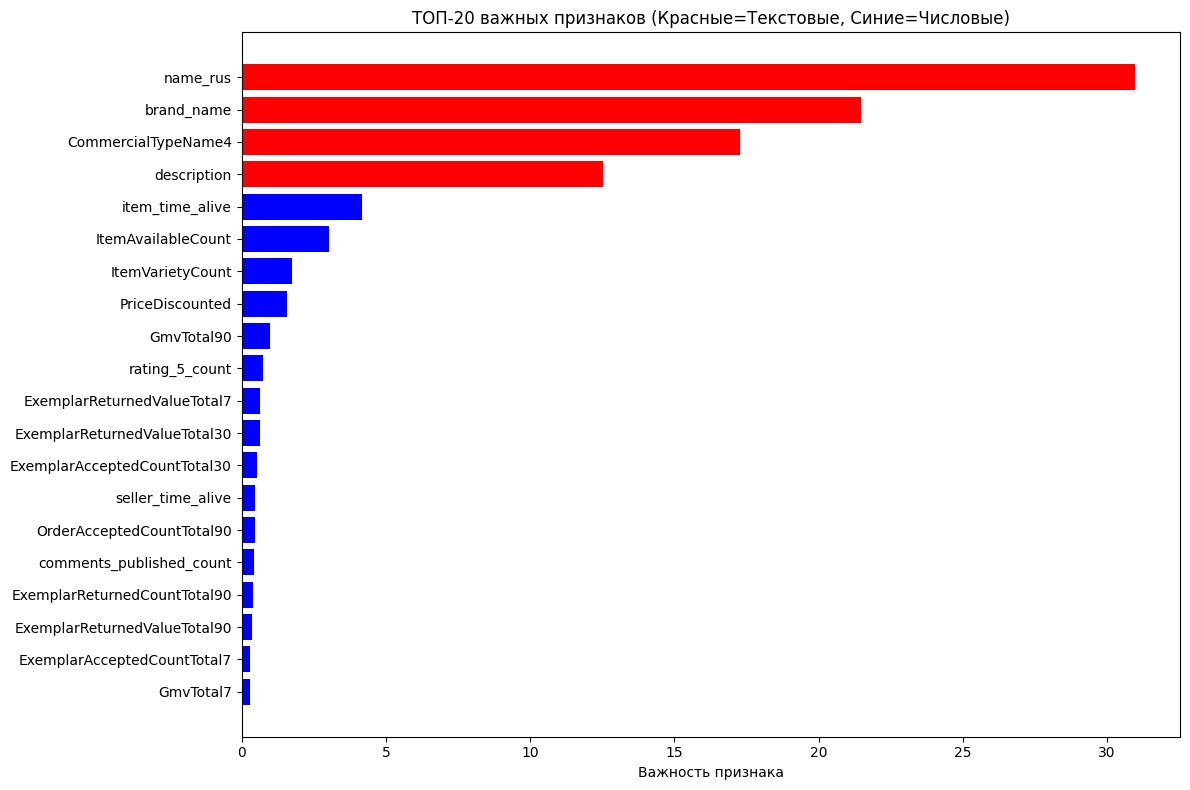


ЭТАП 1: HARD МОДЕЛЬ (без глубокой текстовой обработки)

Генерация признаков для HARD модели...
Добавлено 78 новых числовых признаков для HARD модели

Оптимизированный PHIK анализ для HARD модели...
  Анализируем 119 признаков
  🚫 Исключаем 4 текстовых признаков для PHIK анализа
  Категориальных признаков (≤50 уник, int): 17
  Интервальных признаков: 98
  Вычисление оптимизированной PHIK матрицы...
  ТОП-5 признаков по PHIK с resolution:
    2. ExemplarReturnedCountTotal30_exists 0.2362
    3. ExemplarReturnedValueTotal30_exists 0.2361
    4. ExemplarReturnedValueTotal30_high 0.2361
    5. ExemplarReturnedCountTotal90_exists 0.2332
  ✅ Отобрано 25 ЧИСЛОВЫХ признаков


<Figure size 1200x1000 with 0 Axes>

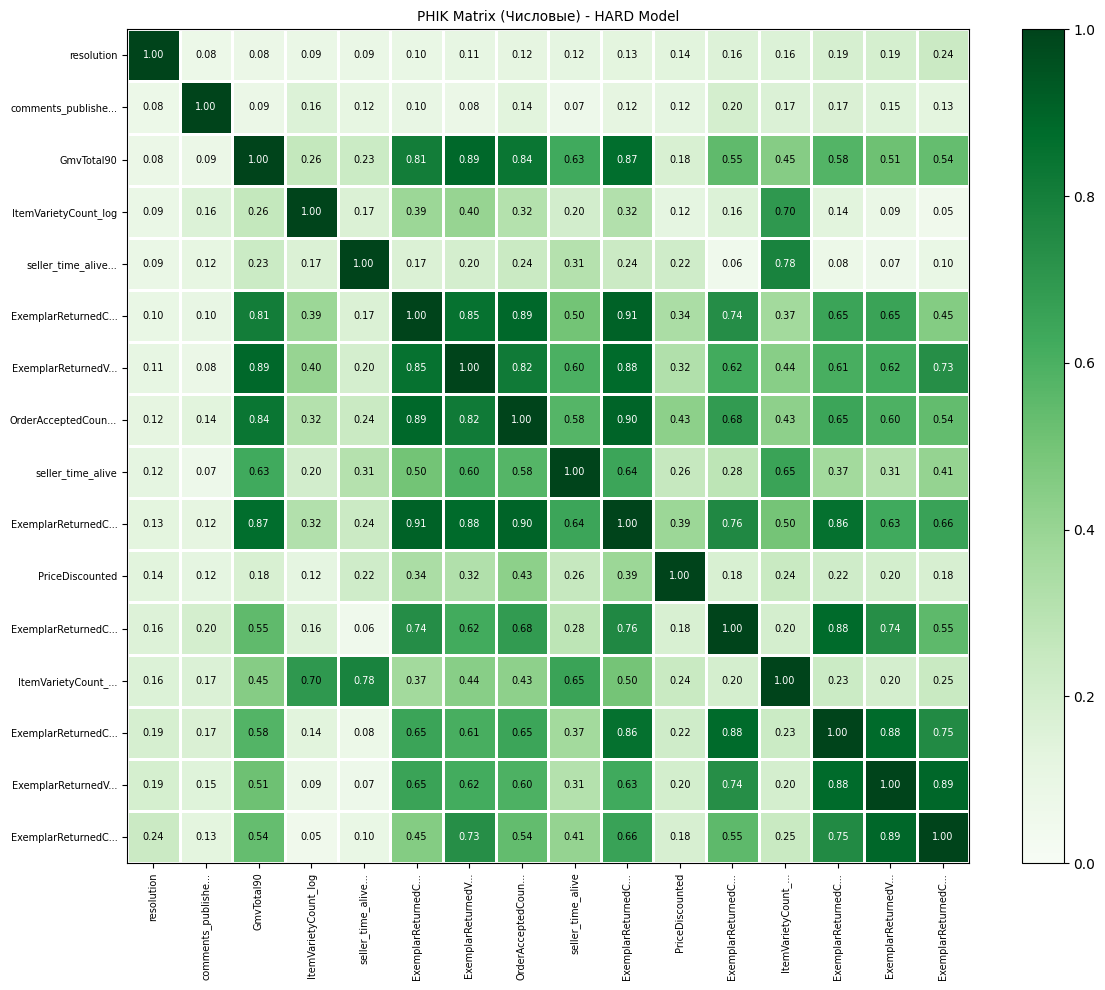


Обучение HARD модели с обработкой текста...
  Признаков: 25
  Категориальных (≤50 уник): 6
  Текстовых: 0
Params: {'allow_writing_files': False, 'custom_metric': 'Recall', 'depth': 12, 'early_stopping_rounds': 10, 'eval_metric': 'F1', 'gpu_ram_part': 0.8, 'iterations': 400, 'l2_leaf_reg': 1, 'learning_rate': 0.1, 'loss_function': 'Logloss', 'random_seed': 255, 'task_type': 'GPU', 'thread_count': 3, 'use_best_model': True, 'used_ram_limit': '12gb', 'verbose': False} -> Mean F1: 0.8041
Params: {'allow_writing_files': False, 'custom_metric': 'Recall', 'depth': 12, 'early_stopping_rounds': 10, 'eval_metric': 'F1', 'gpu_ram_part': 0.8, 'iterations': 400, 'l2_leaf_reg': 3, 'learning_rate': 0.1, 'loss_function': 'Logloss', 'random_seed': 255, 'task_type': 'GPU', 'thread_count': 3, 'use_best_model': True, 'used_ram_limit': '12gb', 'verbose': False} -> Mean F1: 0.8035
Params: {'allow_writing_files': False, 'custom_metric': 'Recall', 'depth': 12, 'early_stopping_rounds': 10, 'eval_metric': 'F1'

<Figure size 800x600 with 0 Axes>

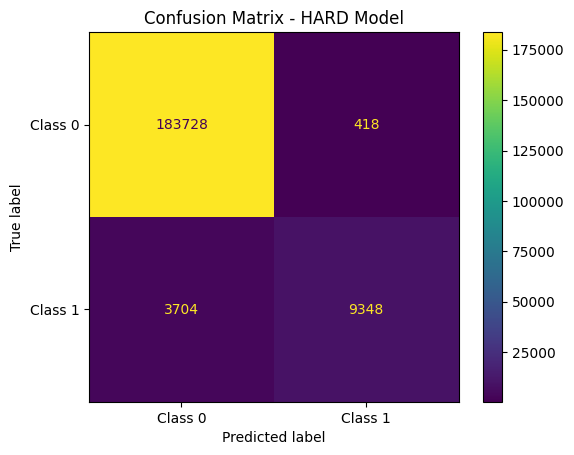

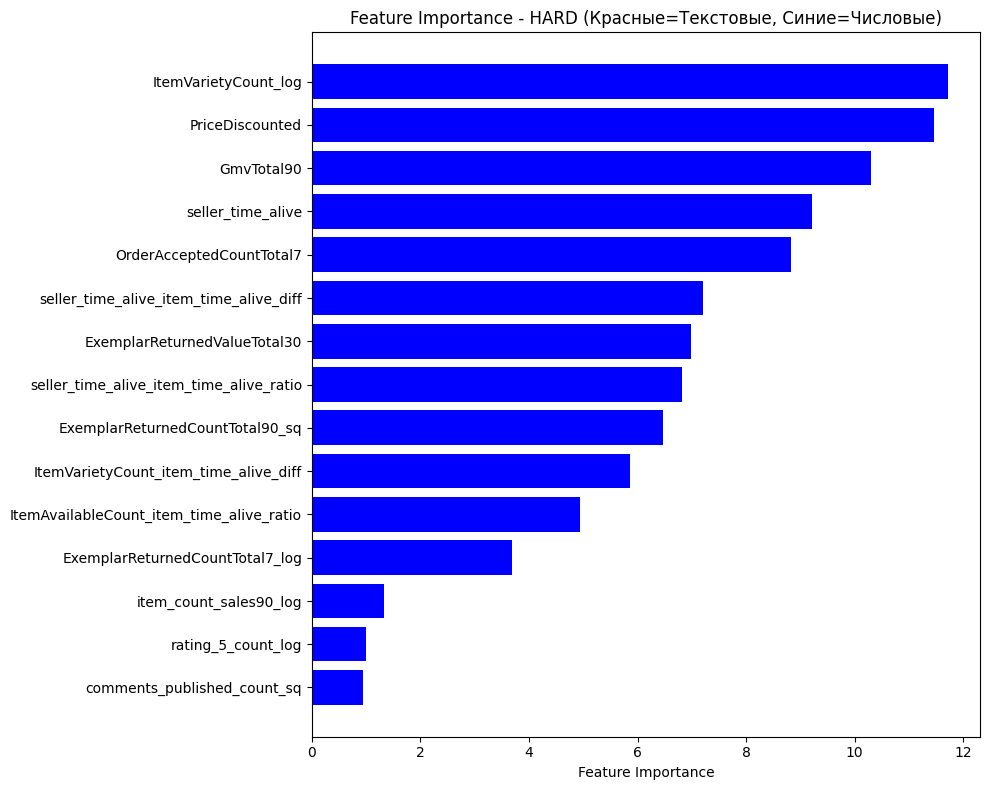


HARD Classification Report:
              precision    recall  f1-score   support

           0       0.98      1.00      0.99    184146
           1       0.96      0.72      0.82     13052

    accuracy                           0.98    197198
   macro avg       0.97      0.86      0.90    197198
weighted avg       0.98      0.98      0.98    197198


Фильтрация HARD...
  ✅ Уверенных и правильных: 186148
  ➡️ Для дальнейшей обработки: 11050
    Класс 0: 180622, Класс 1: 5526

ЭТАП 2: SOFT МОДЕЛЬ (текст: 3-5 слов)

Генерация дополнительных признаков для SOFT модели...
Добавлено 50 дополнительных числовых признаков для SOFT модели

Оптимизированный PHIK анализ для SOFT модели...
  Анализируем 83 признаков
  🚫 Исключаем 4 текстовых признаков для PHIK анализа
  Категориальных признаков (≤50 уник, int): 15
  Интервальных признаков: 64
  Вычисление оптимизированной PHIK матрицы...
  ❌ Ошибка оптимизированной PHIK: f(a) and f(b) must have different signs

Обучение SOFT модели с обработкой 

In [ ]:
def main():
    """Главная функция"""
    print("🚀 TEXT-AWARE PHIK COUNTERFEIT DETECTION PIPELINE")
    print("="*70)
    
    # Пути к файлам
    train_path = 'OZON/ml_ozon_сounterfeit_data/ml_ozon_сounterfeit_train.csv'
    test_path = 'OZON/ml_ozon_сounterfeit_data/ml_ozon_сounterfeit_test.csv'
    
    
    try:
        # Создание pipeline
        final_pipeline = TextAwarePHIKPipeline()
        
        # Обучение
        final_pipeline.fit(train_path, keep_original_features=True)
        
        # Предсказание
        predictions = final_pipeline.predict(test_path)
        
        # Подготовка submission
        df_test = pl.read_csv(test_path)
        try:
            df_test_add = pl.read_csv('ml_ozon_сounterfeit_new_test.csv')
            df_test = df_test.vstack(df_test_add)
        except:
            pass
        
        id_test = df_test['id'].to_list()
        
        # Сохранение результата
        submission = pd.DataFrame({
            'id': id_test,
            'prediction': predictions
        })
        
        submission.to_csv('submission.csv', index=False)
        print("\n✅ Сохранён файл submission.csv с предсказаниями")
        print("🎉 Pipeline выполнен успешно!")
        
        return final_pipeline, predictions
        
    except Exception as e:
        print(f"❌ Ошибка: {e}")
        import traceback
        traceback.print_exc()
        return None, None


if __name__ == "__main__":
    final_pipeline, predictions = main()